<div align='center'>

# Scientific Machine Learning (SciML)

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
#! Always run this cell first to import all necessary libraries and to set up the notebook environment

from scipy.integrate import solve_ivp

from jax import numpy as jnp
from jax import grad, jit, vmap, random, config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"figure.facecolor": 'white', "axes.facecolor": 'white'})

# Physics-Informed Neural Networks (PINNs)

Physics-Informed Neural Networks (PINNs) are a class of neural networks designed to solve problems governed by physical laws, such as differential equations, by embedding these laws directly into the training process. Traditional numerical approaches to solving physics-based problems require discretization methods, such as finite element methods, which can be computationally intensive, especially in high-dimensional spaces. PINNs leverage neural networks to approximate solutions to these problems by incorporating the governing equations, making them both efficient and flexible for high-dimensional and complex physical systems.

### Key Concepts of PINNs

1. **Differential Equations and Physical Laws**: Most physical phenomena can be described by differential equations, which encode how physical quantities like heat, fluid flow, or electromagnetic fields change over time and space. PINNs incorporate these differential equations as constraints in the neural network's loss function.

2. **Trial Solution Approximation**: PINNs use neural networks as trial solutions for the governing differential equations. The neural network parameters are optimized to minimize the residuals (errors) of the differential equations over a domain of interest.

3. **Physics-Based Loss Function**: Instead of only relying on data for training, PINNs also compute a loss based on the differential equations. This helps the model to learn representations that satisfy the physical constraints, leading to better generalization and extrapolation.

4. **Boundary and Initial Conditions**: For differential equations, boundary and initial conditions are crucial. PINNs enforce these conditions in the network by including their residuals as part of the loss function.

5. **Automatic Differentiation**: PINNs rely on automatic differentiation to compute gradients of the network outputs with respect to its inputs. This allows them to compute derivatives necessary for evaluating the differential equation residuals efficiently.

### Setting up a PINN Problem

To create a PINN, let’s go through the main components needed for formulating and solving a problem using this approach.

#### 1. Define the Physical Problem and Governing Equation

Consider a physical problem that can be described by a partial differential equation (PDE). For instance, let’s take the **heat equation** in one spatial dimension:
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
where $ u(x, t) $ represents the temperature at position $ x $ and time $ t $, and $ \alpha $ is the thermal diffusivity constant.

For this example:
- **Domain**: $ x \in [0, L] $ and $ t \in [0, T] $
- **Initial Condition**: $ u(x, 0) = f(x) $
- **Boundary Conditions**: $ u(0, t) = g_1(t) $ and $ u(L, t) = g_2(t) $

#### 2. Construct the Neural Network

Define a neural network to approximate the solution $ u(x, t) $. The inputs to the network are $ x $ and $ t $, and the output is the predicted $ u(x, t) $.

For simplicity, let’s use a fully connected neural network with:
- A specified number of hidden layers and neurons per layer.
- Activation functions like ReLU or tanh, which often work well for approximating continuous functions in physics-based problems.

#### 3. Define the Physics-Informed Loss Function

The loss function in a PINN is composed of multiple terms:
1. **Physics Loss (Residual Loss)**: This term enforces the differential equation. For the heat equation, the physics-based residual is:
   $$
   \text{Residual}(x, t) = \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2}
   $$
   The physics loss is calculated by sampling points in the domain and minimizing the squared residual at each point:
   $$
   \mathcal{L}_{\text{physics}} = \frac{1}{N}\sum_{i=1}^{N} \left( \frac{\partial u(x_i, t_i)}{\partial t} - \alpha \frac{\partial^2 u(x_i, t_i)}{\partial x^2} \right)^2
   $$

2. **Initial Condition Loss**: This term enforces that the solution satisfies the initial condition. For instance:
   $$
   \mathcal{L}_{\text{IC}} = \frac{1}{M}\sum_{j=1}^{M} \left( u(x_j, 0) - f(x_j) \right)^2
   $$

3. **Boundary Condition Loss**: This term enforces that the solution satisfies the boundary conditions. For example:
   $$
   \mathcal{L}_{\text{BC}} = \frac{1}{P}\sum_{k=1}^{P} \left( u(0, t_k) - g_1(t_k) \right)^2 + \frac{1}{Q}\sum_{l=1}^{Q} \left( u(L, t_l) - g_2(t_l) \right)^2
   $$

The total loss combines these terms:
$$
\mathcal{L} = \mathcal{L}_{\text{physics}} + \lambda_{\text{IC}} \mathcal{L}_{\text{IC}} + \lambda_{\text{BC}} \mathcal{L}_{\text{BC}}
$$
where $ \lambda_{\text{IC}} $ and $ \lambda_{\text{BC}} $ are weights that balance the influence of each term.

#### 4. Training the PINN

The training process for a PINN is similar to traditional neural networks:
1. **Sampling Points**: Select points within the domain for computing the physics loss. These points are chosen in a way to cover the entire spatial and temporal range.
2. **Automatic Differentiation**: Use automatic differentiation to compute the derivatives of $ u(x, t) $ with respect to $ x $ and $ t $, as required by the differential equation.
3. **Optimization**: Optimize the neural network parameters to minimize the total loss using a gradient-based optimizer (e.g., Adam or SGD).

## Example of PINNs

Consider the differential equation derived from the energy balance of a body immersed in water:

$$
\frac{d T(t)}{d t} + k T(t) - f(t) = 0,
$$

where:

- $T(t)$ is the temperature,
- $k = 0.5$,
- $f(t) = \exp(5 \sin(2t))$,
- $t$ ranges from $0$ to $10$,
- the initial condition is $T(0) = -5$.

The aim is to estimate the temperature $T(t)$ using a physics-informed neural network (PINN).

The provided code generates training and testing datasets by sampling from the solution of the equation and adding Gaussian noise $\eta$ to the training outputs $Y_{\text{data\_train}}$. This noise is zero-mean with variance $\sigma^2$, denoted as $\eta \sim \mathcal{N}(0, \sigma^2)$. We also have $N_{\text{physics}}$ data points for computing the physics-informed loss.

Included is the code for constructing a multi-layer neural network. The function `dT_dt` computes the gradient of the `Forward` function with respect to its second input. Specifically, `dT_dt(w_b, input)` corresponds to the term $\frac{dT}{dt}$ in the differential equation.

### Tasks:

1. **Data-Only Loss Function**:
   - Complete the loss function using only the data, without incorporating any physics-based information.
   - Train the neural network using gradient descent with:
     - Training data size: $N_{\text{data\_train}} = 500$
     - Testing data size: $N_{\text{data\_test}} = 100$
     - Iterations: $60,\!000$
     - Network architecture: `units = [10, 10, 10, 10, 1]`
     - Learning rate: $\alpha = 0.0005$
   - Plot the true solution, the noisy measurements, and the neural network's prediction at the final iteration.
   - Compute and store the training and testing losses, and plot them against the iteration number with appropriate legends.
   - **Question**: What happens if you change the activation function to ReLU, defined as $\text{ReLU}(x) = \max(x, 0)$?

2. **Physics-Informed Neural Network (PINN)**:
   - Modify the loss function to include physics-based constraints using the `dT_dt` function and the dataset `X_physics`.
   - Train the neural network with:
     - Training data size: $N_{\text{data\_train}} = 50$
     - Testing data size: $N_{\text{data\_test}} = 10$
     - Physics data size: $N_{\text{physics}} = 1,\!000$
     - Iterations: $150,\!000$
     - Network architecture: `units = [10, 10, 10, 10, 1]`
     - Learning rate: $\alpha = 0.0001$
   - Plot the true solution, the noisy measurements, and the neural network's prediction at the final iteration.
   - Compute and store the training and testing losses, and plot them against the iteration number with appropriate legends.

iteration :     0 - Train MSE : 5380.07 - Test  MSE : 5320.39
iteration :  5000 - Train MSE : 1444.32 - Test  MSE : 1431.28
iteration : 10000 - Train MSE : 959.09 - Test  MSE : 931.56


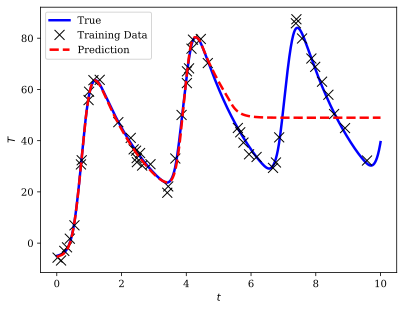

In [2]:
# Random key for reproducibility
key = random.PRNGKey(0)

# Parameters
Nt = 5000  # Number of time points
tf = 10  # Final time
N_data_train = 50  # Number of training data points
N_data_test = 10  # Number of test data points
N_physics = 1000  # Number of physics-based data points
sigma = 2  # Noise standard deviation

# Define the right-hand side (RHS) of the differential equation
def RHS(t, y):
    return -0.5 * y + jnp.exp(5 * jnp.sin(2 * t))

# Solve the differential equation
sol = solve_ivp(RHS, [0, tf], [-5], t_eval=jnp.linspace(0, tf, Nt))

# Extract the solution
t = jnp.array(sol.t).reshape(-1, 1)
y = jnp.array(sol.y[0, :])

# Select random training data points
I_data_train = random.choice(key, Nt, (N_data_train,))
X_data_train = t[I_data_train]
Y_data_train = y[I_data_train] + sigma * random.normal(key, (N_data_train,))

# Select random test data points
I_data_test = random.choice(key, Nt, (N_data_test,))
X_data_test = t[I_data_test]
Y_data_test = y[I_data_test]

# Physics-based data points
X_physics = jnp.linspace(0, tf, N_physics).reshape(-1, 1)

# Initialize the neural network weights
def Init(layer_sizes, key):
    weights = []
    keys = random.split(key, num=len(layer_sizes))

    for i, units in enumerate(layer_sizes):
        if i == 0:
            w = random.uniform(keys[i], (1, units), minval=-1.0, maxval=1.0)
        else:
            w = random.uniform(keys[i], (layer_sizes[i-1], units), minval=-1.0, maxval=1.0)
        b = random.uniform(keys[i], (units,), minval=-1.0, maxval=1.0)
        weights.append([w, b])

    return weights

# Activation function
def activation_function(x):
    return jnp.tanh(x)

# Single layer forward pass
def Layer(w_b, input):
    w, b = w_b
    out = input @ w + b
    return activation_function(out)

# Forward pass through the neural network
def Forward(w_b, input):
    layer_out = input
    for i in range(len(w_b[:-1])):
        layer_out = Layer(w_b[i], layer_out)
    preds = layer_out @ w_b[-1][0] + w_b[-1][1]
    return preds.squeeze()

# Compute the gradient of the forward pass with respect to the input
dT_dt = jit(vmap(grad(Forward, argnums=1), in_axes=(None, 0)))

# Loss function
@jit
def Loss(w_b, input_data, real_data, input_physics):
    pred_data = Forward(w_b, input_data)
    pred_physics = Forward(w_b, input_physics)
    R = dT_dt(w_b, input_physics) - RHS(input_physics, pred_physics.reshape(-1, 1))
    loss = jnp.mean((real_data - pred_data) ** 2) + jnp.mean(R ** 2)
    return loss

# Compute gradients of the loss function
@jit
def Gradients(w_b, input_data, real_data, input_physics):
    return grad(Loss)(w_b, input_data, real_data, input_physics)

# Training parameters
alpha = 1e-4  # Learning rate
epochs = 15000  # Number of training epochs
layer_sizes = [10, 10, 10, 10, 1]  # Neural network architecture

# Initialize weights
w_b = Init(layer_sizes, random.PRNGKey(0))

# Lists to store training and test loss
train_loss = []
test_loss = []

# Training loop
for step in range(epochs):
    loss = Loss(w_b, X_data_train, Y_data_train, X_physics)
    gradients = Gradients(w_b, X_data_train, Y_data_train, X_physics)

    for j in range(len(w_b)):
        w_b[j][0] -= alpha * gradients[j][0]
        w_b[j][1] -= alpha * gradients[j][1]

    if step % 1000 == 0:
        train_loss.append(loss)
        test_loss.append(Loss(w_b, X_data_test, Y_data_test, X_physics))
    if step % 5000 == 0:
        print(f"iteration : {step:5d} - Train MSE : {loss:.2f} - Test  MSE : {Loss(w_b, X_data_test, Y_data_test, X_physics):.2f}")

# Plotting
plt.figure(1, dpi=150)
plt.plot(t, y, 'b', lw=2.5, label='True')
plt.plot(X_data_train, Y_data_train, 'xk', ms=10, label='Training Data')
plt.plot(t, Forward(w_b, t).squeeze(), '--r', lw=2.5, label='Prediction')
plt.xlabel("$t$")
plt.ylabel("$T$")
plt.legend()
plt.show()